In [22]:
import numpy
import os

# Training Data

# 70, 740, 856

image_path = 'numpy_data/Ultrasound Volumes/'
segmentation_path = 'numpy_data/Patient Segmentations/'
image_file_list = [image_path + f for f in os.listdir(image_path) if f.endswith('.npy')]
segmentation_file_list = [segmentation_path + f for f in os.listdir(segmentation_path) if f.endswith('.npy')]


cropped_dimensions = []
segmentation_arrays = []
for file in segmentation_file_list:
    segmentation_array = numpy.load(file)
    x, y, z = numpy.where(segmentation_array != 0)
    segmentation_array = segmentation_array[min(x):max(x)+1, min(y):max(y)+1, min(z):max(z)+1]
    #save into array
    dim = [min(x), max(x), min(y), max(y), min(z), max(z)]
    cropped_dimensions.append(dim)
    #resize
    segmentation_array = numpy.resize(segmentation_array, (128, 128, 128))
    segmentation_array = numpy.expand_dims(segmentation_array, 3)
    segmentation_arrays.append(segmentation_array)
    

image_arrays = []
for index, file in enumerate(image_file_list):
    image_array = numpy.load(file)
    dim = cropped_dimensions[index]
    image_array = image_array[dim[0]:dim[1]+1, dim[2]:dim[3]+1, dim[4]:dim[5]+1]
    image_array = numpy.resize(image_array, (128, 128, 128))
    image_array = numpy.expand_dims(image_array, 3)
    image_arrays.append(image_array)


stacked_image_array = numpy.stack(image_arrays)
stacked_segmentation_array = numpy.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/stacked_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/stacked_segmentation_array'

numpy.save(image_file, stacked_image_array)
numpy.save(segmentation_file, stacked_segmentation_array)

(24, 128, 128, 128, 1)
(24, 128, 128, 128, 1)


In [23]:
# Testing Data

image_path = 'numpy_data/Ultrasound Volumes/Testing Data/'
segmentation_path = 'numpy_data/Patient Segmentations/Testing Data/'
image_file_list = [image_path + f for f in os.listdir(image_path) if f.endswith('.npy')]
segmentation_file_list = [segmentation_path + f for f in os.listdir(segmentation_path) if f.endswith('.npy')]


cropped_dimensions = []
segmentation_arrays = []
for file in segmentation_file_list:
    segmentation_array = numpy.load(file)
    x, y, z = numpy.where(segmentation_array != 0)
    segmentation_array = segmentation_array[min(x):max(x)+1, min(y):max(y)+1, min(z):max(z)+1]
    #save into array
    dim = [min(x), max(x), min(y), max(y), min(z), max(z)]
    cropped_dimensions.append(dim)
    #resize
    segmentation_array = numpy.resize(segmentation_array, (128, 128, 128))
    segmentation_array = numpy.expand_dims(segmentation_array, 3)
    segmentation_arrays.append(segmentation_array)
    

image_arrays = []
for index, file in enumerate(image_file_list):
    image_array = numpy.load(file)
    dim = cropped_dimensions[index]
    image_array = image_array[dim[0]:dim[1]+1, dim[2]:dim[3]+1, dim[4]:dim[5]+1]
    image_array = numpy.resize(image_array, (128, 128, 128))
    image_array = numpy.expand_dims(image_array, 3)
    image_arrays.append(image_array)


stacked_image_array = numpy.stack(image_arrays)
stacked_segmentation_array = numpy.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/stacked_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/stacked_segmentation_array'

numpy.save(image_file, stacked_image_array)
numpy.save(segmentation_file, stacked_segmentation_array)

(6, 128, 128, 128, 1)
(6, 128, 128, 128, 1)


In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


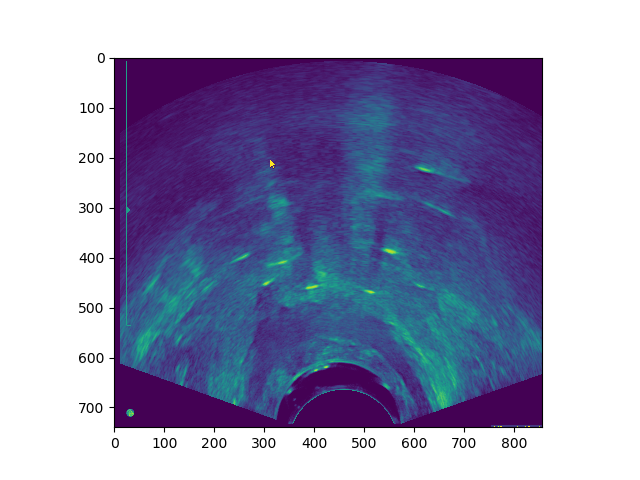

In [28]:
import matplotlib.pyplot as plt

test_array = numpy.load('numpy_data/Ultrasound Volumes/ultrasound03.npy')
test_array2 = numpy.load('numpy_data/Patient Segmentations/brachy_patient03.npy')
plt.imshow(test_array[11])

In [37]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

<IPython.core.display.Javascript object>


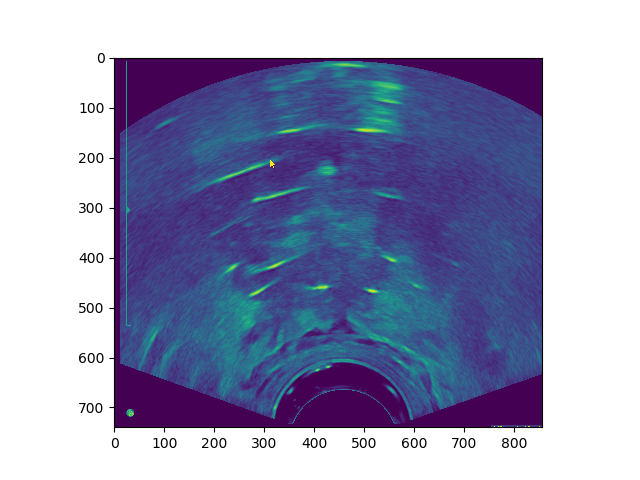

<IPython.core.display.Javascript object>


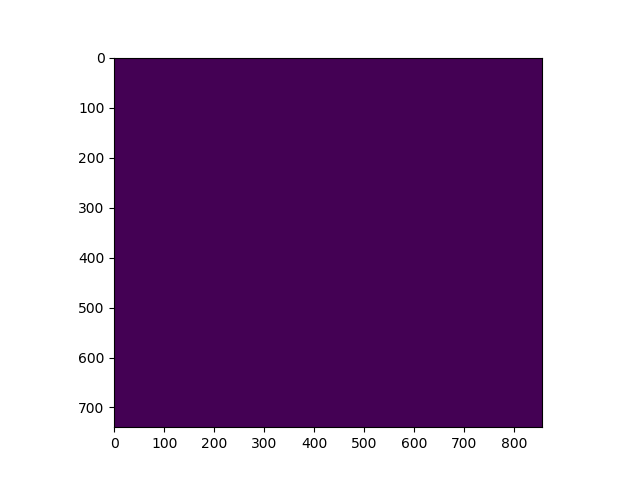

In [38]:
multi_slice_viewer(test_array)
multi_slice_viewer(test_array2)

In [13]:
import os 
import numpy

image_path = 'numpy_data/Ultrasound Volumes/'
segmentation_path = 'numpy_data/Patient Segmentations/'
image_file_list = [image_path + f for f in os.listdir(image_path) if f.endswith('.npy')]
segmentation_file_list = [segmentation_path + f for f in os.listdir(segmentation_path) if f.endswith('.npy')]

# 60, 410, 550
for file in segmentation_file_list:
    segmentation_array = numpy.load(file)
    x, y, z = numpy.where(segmentation_array != 0)
    segmentation_array = segmentation_array[min(x):max(x)+1, min(y):max(y)+1, min(z):max(z)+1]
    segmentation_array = numpy.resize(segmentation_array, (60, 410, 550))
    print(segmentation_array.shape)

(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
(60, 410, 550)
